In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
import sys
sys.path.append(os.path.abspath("../../../../"))
import Constants as c
import Utilities as utils

In [2]:

# file_line = "h1_model_performance_05_27_2020.csv"
file_line = "h2_metrics_h1_DT_05_29_2020.csv"

df = pd.read_csv(file_line)

print(len(df))
# df.where(df[c.T_RECORDS] > 2, inplace = True)
df = utils.remove_outlier(df, c.MAE)
na_percent = .50

print(len(df))

3456
2829


In [3]:
def hypothesisTest_Effort(model_records, model, task, pred, mean, sample_size, na_percent):
    print("Hypothesis test for {0} and task = '{1}'".format(model, task))

    task_filter = True

    if task != "ALL":
        task_filter = model_records[c.TASK] == task
        # model_records = pd.concat([filter])
    
    if model == c.MODULE:
        filter1 = model_records[c.MODEL] == c.MODULE_CC
        filter2 = model_records[c.MODEL] == c.MODULE_EC
    else:
        filter1 = model_records[c.MODEL] == c.LINE_CC
        filter2 = model_records[c.MODEL] == c.LINE_EC

    na_filter = model_records[c.P_NA] <= na_percent

    filter = (filter1 | filter2) & task_filter & na_filter
    # filter = model_records[c.MODEL] == model
    model_records = model_records[filter].sample(n=sample_size, random_state=0)

    num_records = len(model_records)
    model_records_mean = round(model_records[pred].mean(),2)
    num_records_std = round(model_records[pred].std(),2)
    num_records_min = round(model_records[pred].min(),2)
    num_records_max = round(model_records[pred].max(),2)

    print("Number of records: {0}".format(num_records))
    print("Sample mean: ", model_records_mean)
    print("Sample std: ", num_records_std)
    print("Sample min: ", num_records_min)
    print("Sample max: ", num_records_max)

    length = model_records.size

    conf_int = stats.norm.interval(0.95, loc=model_records_mean, scale=num_records_std/np.sqrt(length))
    print("95% CI: ", conf_int)
    
    alpha = 0.05
    is_gaussian = utils.gaussian_test(model_records[pred], alpha)

    if is_gaussian:
        if num_records <= 30:
            utils.one_sample_t_test(model_records[pred], mean, alpha)
        else:
            utils.one_sample_z_test(model_records[pred], mean, alpha)
    else:
        utils.one_sample_sign_test(model_records[pred], mean, alpha)

    # model_records.boxplot(column=[pred])
    plt.figure(figsize=(8,3))
    plt.tight_layout()
    
    sb.set(style="dark", palette="pastel")
    ax = sb.distplot(model_records[pred], kde=False, hist_kws={"histtype": "stepfilled", "alpha": 0.7, "linewidth": 3, "label":model})
    ax.set_title('PRED25 Distributions for {0} (task = {1})'.format(model, task))
    plt.ylabel("Count")

In [4]:
task = "ALL"
sample_size = 40

Hypothesis test for Module and task = 'ALL'
Number of records: 40
Sample mean:  0.64
Sample std:  0.15
Sample min:  0.33
Sample max:  0.88
95% CI:  (0.6271074840235464, 0.6528925159764536)
Shapiro p-value:  0.03717709332704544
Shapiro Test: Sample does not look Gaussian (reject H0)
One Sample Sign Test p-value:  0.9999478446492328
One Sample Sign Test: 0.64 sample median is likely to be greater than 0.53 (fail to reject H0)


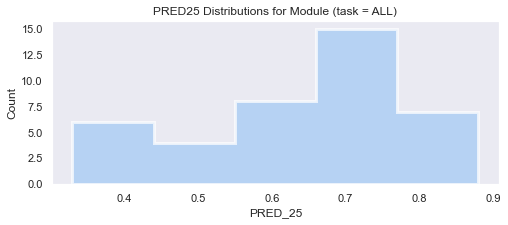

In [5]:
hypothesisTest_Effort(df.copy(), c.MODULE, task, c.PRED_25, 0.53, sample_size, na_percent)

Hypothesis test for Line and task = 'ALL'
Number of records: 40
Sample mean:  0.66
Sample std:  0.14
Sample min:  0.28
Sample max:  0.97
95% CI:  (0.6479669850886434, 0.6720330149113567)
Shapiro p-value:  0.9569680094718933
Shapiro Test: Sample looks Gaussian (fail to reject H0)
One Sample Z-test p-value:  1.0
One Sample Z-Test: 0.66 sample mean is likely to be greater than 0.33 (fail to reject H0)


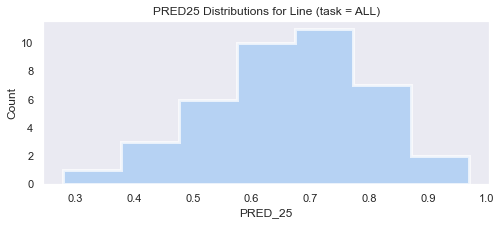

In [6]:
hypothesisTest_Effort(df.copy(), c.LINE, task, c.PRED_25, 0.33, sample_size, na_percent)